# Objective and Data Description

# 1. Data Preparation
- Import libs 
- Load raw data to Jupyter
- Check shape, datatype, convert datatype if needed
- Handle missing value (Numerical data: replace null by mode, Categorical data: using DecisionTree to predict the value), outlier

In [93]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.linear_model import LinearRegression ,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [94]:
data = 'data/cardataset.csv'
df = pd.read_csv(data)
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [95]:
#lowercase column names and values of categorical cols
df.columns = df.columns.str.lower().str.replace(' ', '_')
cat_col = list(df.columns[df.dtypes == 'object'])
for i in cat_col:
    df[i] = df[i].str.lower().str.replace(' ','_')

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(3), int64(5

In [97]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

**Handle "Null value":**
- Numerical columns: imputed by **mode** value
- Catergorical columns:
  - Delete rows with **'null'** value in **'engine_fuel_type', 'number_of_doors'** because the ratio of null value is quite low in these columns
  - Do not use columns **'market_category'** in feature selection because it has over **30% null**. We can use **Treemodels** to predict the missing lables in this column but it might cost the resource and lead the bias in the final result.  

In [98]:
#null values
numeric_null = ['engine_hp','engine_cylinders']
category_null = ['engine_fuel_type', 'number_of_doors']

    

In [99]:
for i in numeric_null:
    mode = df[i].mode()[0]
    df[i] = df[i].fillna(mode)

In [100]:
df = df.dropna(subset =['engine_fuel_type', 'number_of_doors'])

# 2. EDA and Standardization

C:\Users\v121256\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


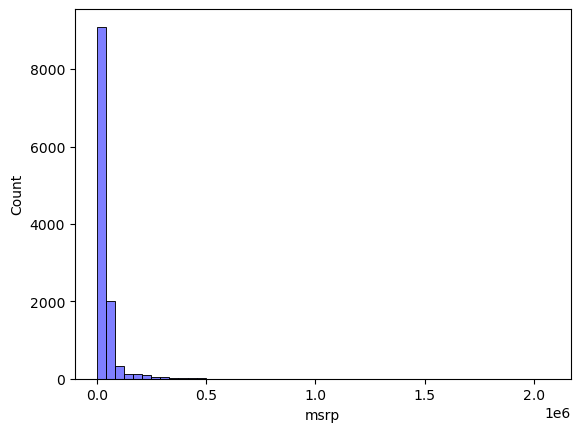

In [101]:
# Price distribution
price = df['msrp']
sns.histplot(price, color = 'b', bins= 50,alpha =0.5)
plt.show()

In [102]:
price.describe().astype('int')

count      11905
mean       40560
std        60076
min         2000
25%        21000
50%        29995
75%        42200
max      2065902
Name: msrp, dtype: int32

In [103]:
price.skew()

11.795091321805206

Since the price distribution is high variance(**std = 600076** while **mean = 40560**) and it's right-skewed, we will use log scale to normalize data. Price dataset is obviously higher than -1, we can use log1p for normalizing

C:\Users\v121256\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='msrp', ylabel='Count'>

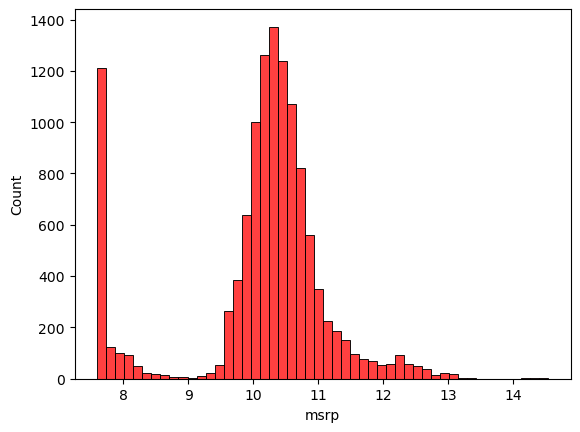

In [104]:
price_log = np.log1p(price)
sns.histplot(price_log, color = 'r', bins = 50)

In [105]:
# Calculate Q1, Q3, IQR
df_q1 = df['msrp'].quantile(0.25)
df_q3 = df['msrp'].quantile(0.75)
iqr = df_q3 - df_q1
lower_bound = df_q1 - iqr*1.5
upper_bound = df_q3 + iqr*1.5
print('lower bound: ', lower_bound)
print('upper bound: ',upper_bound)
df_outlier = df[df['msrp'] >= upper_bound]


lower bound:  -10800.0
upper bound:  74000.0


In [106]:
# Corelation of nummeric columns
df_copy = df_outlier.copy()
df_copy['price_log'] = price_log
#all numeric cols of df
df_copy_num = df_copy.select_dtypes(exclude = 'object')


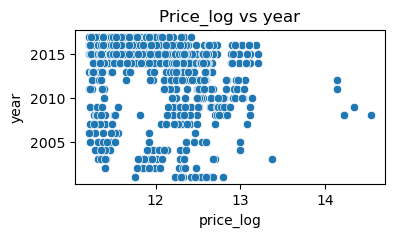

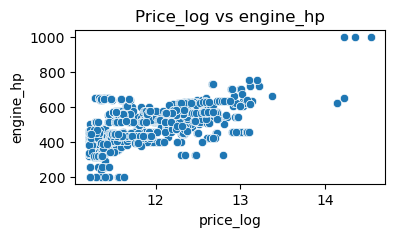

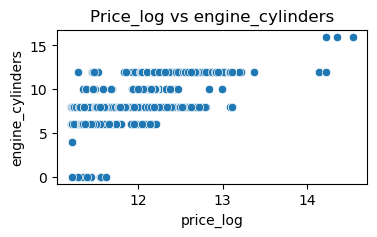

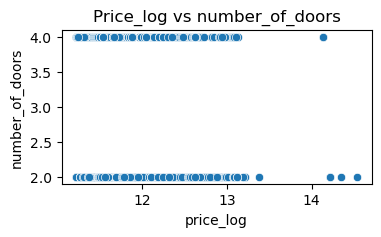

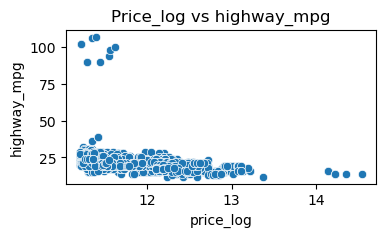

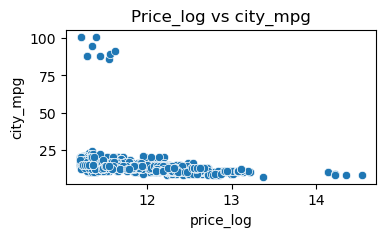

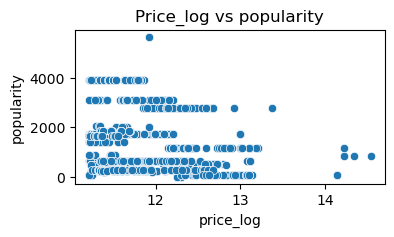

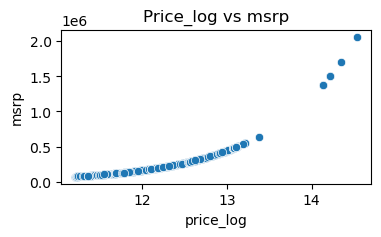

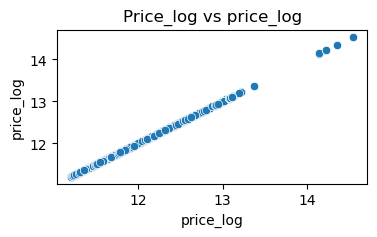

In [107]:
for i in df_copy_num.columns:
    plt.figure(figsize = (4,2))
    sns.scatterplot(data=df_copy_num, x = 'price_log',  y = i)
    plt.xlabel('price_log')
    plt.ylabel(i)
    plt.title(f'Price_log vs {i}')
    plt.show()
    

# 3. Feature engineering and Feature selection

In [108]:
df_copy.select_dtypes(include ='object').nunique()

make                  28
model                159
engine_fuel_type       7
transmission_type      4
driven_wheels          3
market_category       31
vehicle_size           3
vehicle_style          5
dtype: int64

There are some variables having high cardinality such as: **make, model, market_category, vehicle_style** To reduce the complexity and over-fitting, we need to transform a bit in these columns

In [109]:
# Onehotencoder
cate_variables=['engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_size', 'number_of_doors']


In [110]:
encoder = OneHotEncoder(sparse =False)
encoded_array_1 = encoder.fit_transform(df_copy[cate_variables])
encoded_df = pd.DataFrame(encoded_array_1, columns =encoder.get_feature_names_out(cate_variables))
encoded_df

C:\Users\v121256\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,engine_fuel_type_diesel,engine_fuel_type_electric,engine_fuel_type_flex-fuel_(premium_unleaded_required/e85),engine_fuel_type_flex-fuel_(unleaded/e85),engine_fuel_type_premium_unleaded_(recommended),engine_fuel_type_premium_unleaded_(required),engine_fuel_type_regular_unleaded,transmission_type_automated_manual,transmission_type_automatic,transmission_type_direct_drive,transmission_type_manual,driven_wheels_all_wheel_drive,driven_wheels_four_wheel_drive,driven_wheels_rear_wheel_drive,vehicle_size_compact,vehicle_size_large,vehicle_size_midsize,number_of_doors_2.0,number_of_doors_4.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
989,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
990,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
991,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [111]:
df_copy['age'] = 2017 - df['year']
def keep_maj(df,col_name):
    df_large = pd.DataFrame(df[col_name].value_counts().cumsum()/ df[col_name].value_counts().sum()< 0.80)
    majority_list = list(df_large[df_large.values == True].index)
    return majority_list

In [112]:
high_card_list = ['make', 'market_category', 'vehicle_style', 'age']
high_card_dict = dict.fromkeys(high_card_list)
for i in high_card_list:
    values = keep_maj(df_copy,i)
    high_card_dict[i]= values
for key, values in high_card_dict.items():
    for value in values:
        df_copy['%s_%s' % (key, value)] = (df_copy[key] == value).astype(int)
        

In [113]:
df_copy = pd.concat([df_copy, encoded_df], axis =1)
df_copy.drop(columns = high_card_list, inplace = True)
df_copy.drop(columns = cate_variables, inplace = True)


In [114]:
del df_copy['model']
del df_copy['year']
del df_copy['msrp']

In [115]:
df_copy = df_copy.dropna()

# 4. Data Spliting

In [116]:
target_vector = df_copy['price_log']
Feature_matrix = df_copy.loc[:, df_copy.columns != 'price_log']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(Feature_matrix, target_vector, test_size=0.2, random_state=42)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (136, 50)
Training labels shape:  (136,)
Test data shape:  (34, 50)
Test labels shape:  (34,)


# 5. Modeling

In [118]:
reg = LinearRegression()
# Fit the linear regression model to the training data
reg.fit(X_train, y_train)

# Predict on the model
y_pred_li = reg.predict(X_test)
y_pred_li_inverse = np.exp(y_pred_li)
y_test_inverse = np.exp(y_test)

# 6. Evaluation

In [119]:
score = pd.DataFrame(index = ['MSE', 'RMSE', 'MAE', 'Test R2'])


Text(0.5, 1.0, 'Actual and Predicted Price')

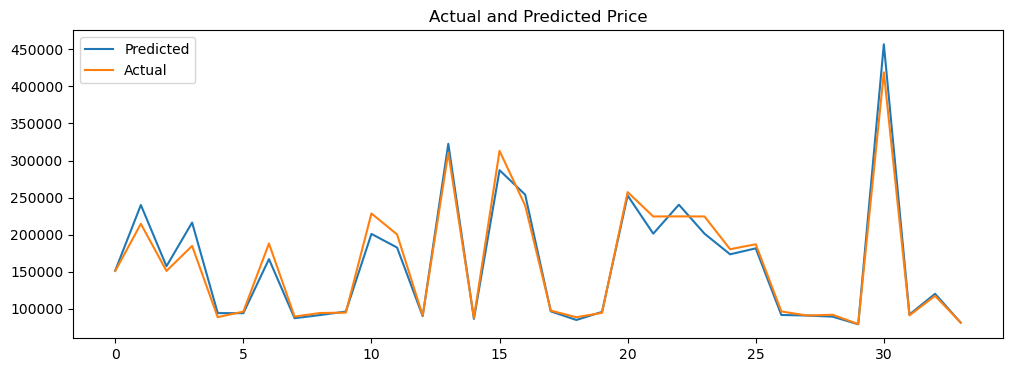

In [120]:
# plot actual and predicted values
plt.figure(figsize=(12,4))
plt.plot((y_pred_li_inverse)[:100])
plt.plot((np.array(y_test_inverse)[:100]))
plt.legend(["Predicted","Actual"])
plt.title('Actual and Predicted Price', fontsize=12)

In [121]:
 # Calculating Evaluation Matrix
mse = mean_squared_error(y_test_inverse,y_pred_li_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred_li)
r2 = r2_score(y_test,y_pred_li)
# Printing Evaluation Matrix
print("MSE :" , mse)
print("RMSE :" ,rmse)
print("MAE :" ,mae)
print("Test R2 :" ,r2)

MSE : 211500937.74110574
RMSE : 14543.071812416581
MAE : 0.04878050076032354
Test R2 : 0.981762361668384


**Cross- Validation & Hyperparameter Tuning**

In [122]:
# Define the model
reg_2 = LinearRegression()

# Define the parameters to be optimized
param_grid = {'fit_intercept': [True, False]}

# Perform grid search
grid_search = GridSearchCV(reg_2, param_grid, cv=7, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             return_train_score=True, scoring='r2')

In [123]:
# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best R2 score: ", grid_search.best_score_)
     

Best parameters:  {'fit_intercept': True}
Best R2 score:  0.860364137387309


In [124]:
# Use the best parameter to train the model
best_reg = grid_search.best_estimator_
best_reg.fit(X_train, y_train)
y_pred_li2 = best_reg.predict(X_test)
y_pred_li2_inverse = np.exp(y_pred_li2)


Text(0.5, 1.0, 'Actual and Predicted Price')

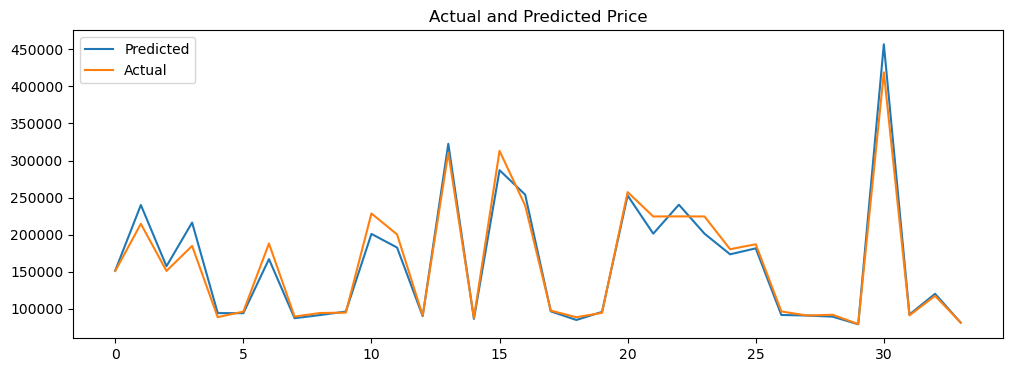

In [125]:
plt.figure(figsize=(12,4))
plt.plot((y_pred_li2_inverse)[:100])
plt.plot((np.array(y_test_inverse)[:100]))
plt.legend(["Predicted","Actual"])
plt.title('Actual and Predicted Price', fontsize=12)

# 7. Regularization and Fine-Tuning model

In [126]:
# Defining a function to print evaluation matrix
def evaluate_model(model, y_test, y_pred):
    # Apply inverse log transformation to y_test and y_pred as we have used log transformation
    total_features = list(X_train.columns)
    y_t = np.exp(y_test)
    y_p = np.exp(y_pred)
    y_train2 = np.exp(y_train)
    y_train_pred = np.exp(model.predict(X_train))
    
  # Calculating Evaluation Matrix
    mse = round(mean_squared_error(y_t,y_p),2)
    rmse = round(np.sqrt(mse),2)
    mae = round(mean_absolute_error(y_t,y_p),2)
    r2 = round(r2_score(y_t,y_p),2)
   

  # Printing Evaluation Matrix
    print("MSE :" , mse)
    print("RMSE :" ,rmse)
    print("MAE :" ,mae)
    print("Test R2 :" ,r2)



  # plot actual and predicted values
    plt.figure(figsize=(12,4))
    plt.plot((y_p))
    plt.plot((np.array(y_t)))
    plt.legend(["Predicted","Actual"])
    plt.title('Actual and Predicted Car Price', fontsize=12)

    try:
        importance = model.feature_importances_
    except:
        importance = model.coef_
        importance = np.absolute(importance)
    if len(importance)==len(total_features):
        pass
    else:
        importance = importance[0]

  # Feature importances
    feat = pd.Series(importance, index=total_features)
    plt.figure(figsize=(7,4))
    plt.title('Feature Importances (top 5) for '+str(model), fontsize = 12)
    plt.xlabel('Relative Importance')
    feat.nlargest(5).plot(kind='barh')


    model_score = [mse,rmse,mae,r2]
    return model_score
     

**Adding score of linear_regression_model and linear_regression_tuned model to score table**

MSE : 211500937.74
RMSE : 14543.07
MAE : 9808.51
Test R2 : 0.97
MSE : 211500937.74
RMSE : 14543.07
MAE : 9808.51
Test R2 : 0.97


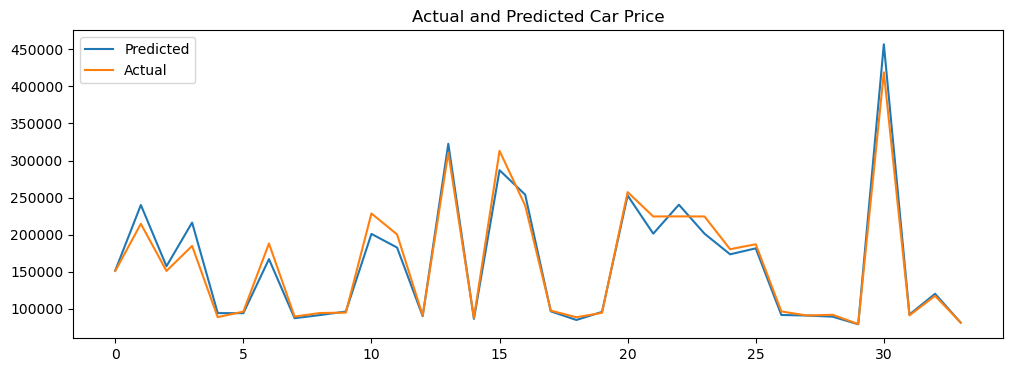

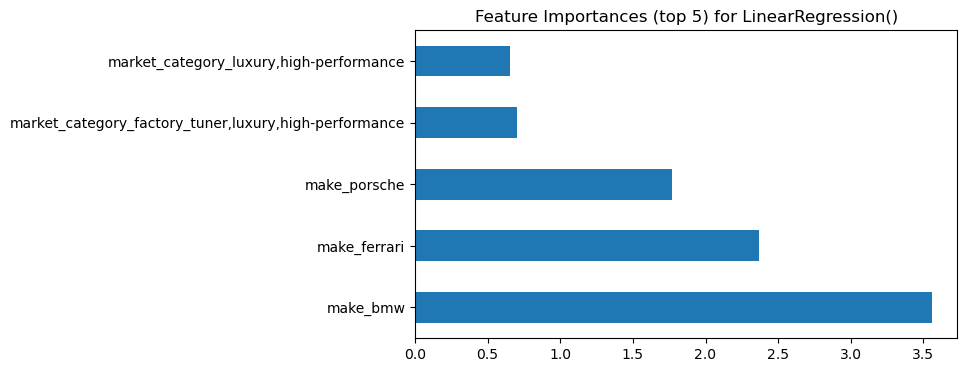

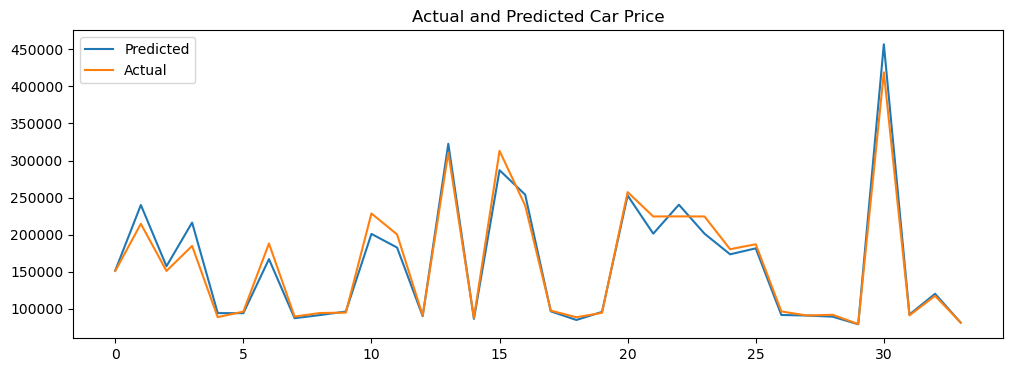

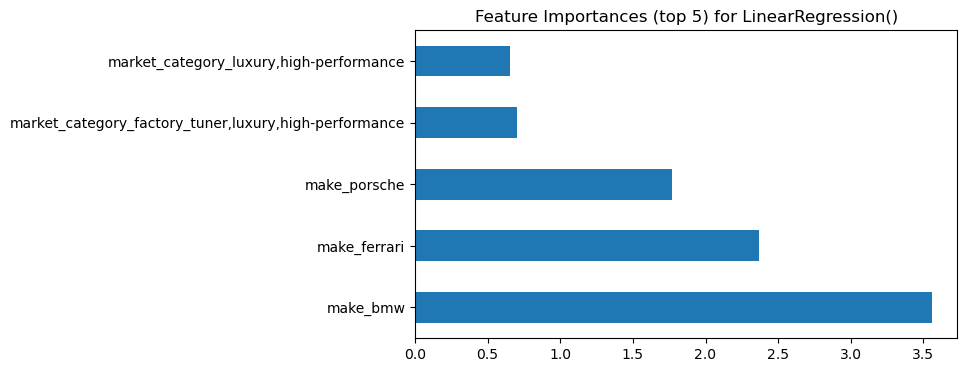

In [127]:
linear_regression_score = evaluate_model(reg, y_test, y_pred_li)
linear_regression_best_score = evaluate_model(best_reg, y_test, y_pred_li2)
score['Linear regression'] = linear_regression_score
score['Linear regression tuned'] = linear_regression_best_score

In [83]:
score

,Linear regression,Linear regression tuned,Lasso regression
MSE,2.115009e+08,2.115009e+08,-2147483648
RMSE,1.454307e+04,1.454307e+04,-2147483648
MAE,9.808510e+03,9.808510e+03,43272
Test R2,9.700000e-01,9.700000e-01,0


# 8. Result Presentation